# Problem statement:

We aim to create a custom convolutional neural network (CNN) model capable of accurately identifying melanoma—a dangerous form of skin cancer. Detecting melanoma early is crucial, as it accounts for a significant portion of skin cancer-related deaths. By developing an image evaluation solution that alerts dermatologists about potential melanoma cases, we can significantly reduce the manual effort required for diagnosis. 

Our goal is to build a multiclass classification model using TensorFlow to achieve this.

### Importing Skin Cancer Data
Taking necessary actions to read the data

In [1]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D


import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

We are setting up the file paths for training and testing images in this assignment. 

The dataset consists of approximately 2357 images related to different types of skin cancer. Within both the train and test subdirectories, there are 9 sub-directories, each corresponding to a specific skin cancer type. These sub-directories contain the relevant images for classification. 

In [3]:
path_to_train_directory = r"D:\Upgrad Docs\Skin Cancer\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train"
path_to_test_directory = r"D:\Upgrad Docs\Skin Cancer\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Test"

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [6]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


# Dataset Creation

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [11]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation
#### Visualize one instance of all the nine classes present in the dataset

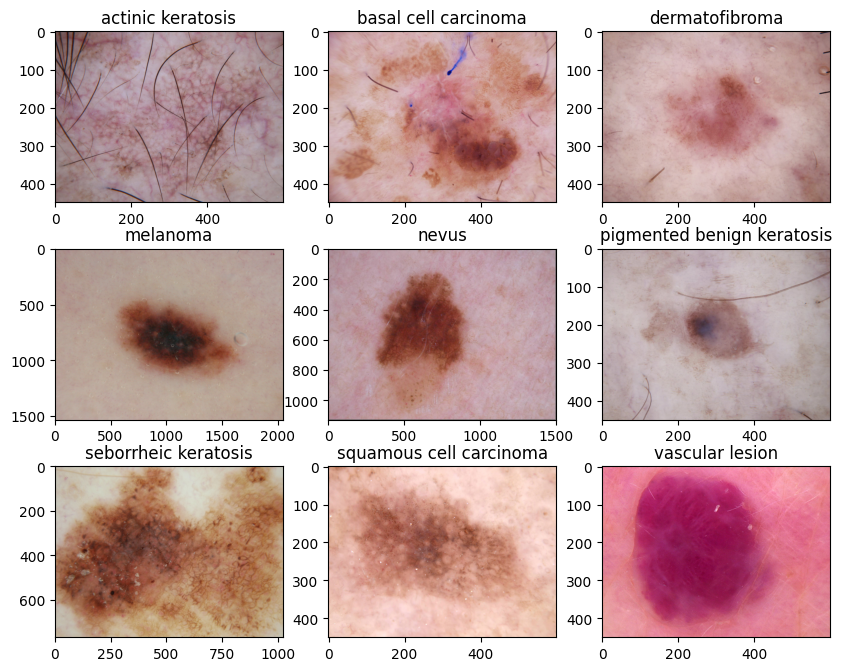

In [12]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10,8))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

# Model Building & training
### Create the model
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

We are embarking on the following steps to build a Convolutional Neural Network (CNN) model for accurate multi-class classification:

1. Model Creation:
    * Our goal is to create a CNN model capable of detecting 9 different classes present in the dataset.
    * During model construction, we’ll rescale the images to normalize pixel values within the range of (0, 1).
2. Optimization and Loss Function Selection:
    * We’ll carefully choose an appropriate optimizer and loss function for training the model.
    * The optimizer guides the model’s weight updates during training, while the loss function quantifies the difference between predicted and actual values.
3. Training the Model:
    * We’ll train the model for approximately 20 epochs (training iterations).
    * Each epoch involves feeding the dataset through the model, adjusting weights, and fine-tuning the model’s performance.
4. Graph Plotting for Evaluation:
    * After fitting the model, we’ll analyze the results.
    * By plotting graphs, we’ll assess whether the model exhibits signs of overfitting (memorizing the training data) or underfitting (lacking complexity).

In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.2112 - loss: 5.0453 - val_accuracy: 0.3043 - val_loss: 1.9220
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3198 - loss: 1.8824 - val_accuracy: 0.4810 - val_loss: 1.6368
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4645 - loss: 1.5211 - val_accuracy: 0.5056 - val_loss: 1.4883
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5448 - loss: 1.3312 - val_accuracy: 0.3691 - val_loss: 1.8003
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.5590 - loss: 1.3402 - val_accuracy: 0.5235 - val_loss: 1.3967
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.6135 - loss: 1.0830 - val_accuracy: 0.4720 - val_loss: 1.4790
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6510 - loss: 0.9928 - val_accuracy: 0.4564 - val_loss: 1.5784
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7192 - loss: 0.8233 - val_accuracy: 0.5324 - val_loss: 1.5

### Visualizing training results

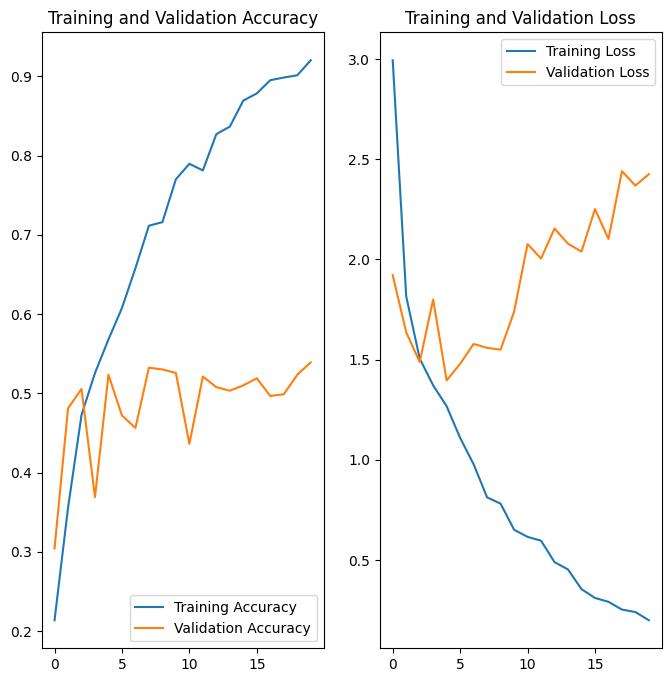

In [17]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:
Here are the observations from the model training process:

1. Training Accuracy vs. Validation Accuracy:
    * During training, the training accuracy consistently increases over time.
    * However, the validation accuracy plateaus at around 53%.
    * This discrepancy suggests that the model performs well on the training data but struggles to generalize to unseen validation data.
2. Training Loss vs. Validation Loss:
    * As the model trains (over epochs), the training loss decreases.
    * Surprisingly, the validation loss increases during the same period.
    * This divergence indicates that the model is overfitting—fitting too closely to the training data and not generalizing well.
3. Accuracy Gap:
    * The gap between training accuracy and validation accuracy is substantial.
    * Achieving only around 53% accuracy on the validation set is suboptimal.
    * Such a noticeable difference is a clear sign of overfitting.

In summary, addressing the overfitting issue is crucial to improve the model’s performance on unseen data

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

We’re addressing the issue of underfitting and overfitting by selecting an appropriate data augmentation strategy. Here’s what it involves:

1. Understanding Overfitting:
    * Overfitting occurs when a model learns too much from the training data and performs poorly on unseen data.
    * It often happens when the training dataset is small.
2. Data Augmentation:
* Data augmentation generates additional training examples by applying random transformations to existing images.
* These transformations create believable variations, such as rotations, flips, zooms, and shifts.
* By exposing the model to diverse data, we help it generalize better to unseen examples.

In summary, data augmentation enhances the model’s ability to handle different aspects of the data, reducing the risk of overfitting.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

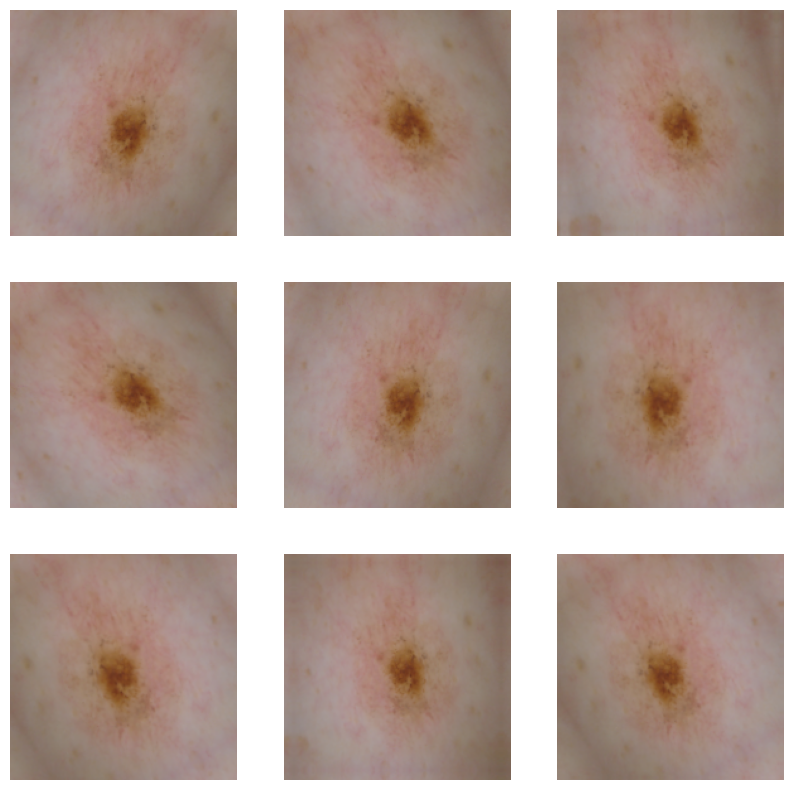

In [19]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data :

We’re embarking on the following steps to build and train a Convolutional Neural Network (CNN) model using augmented data:

1. Model Creation:
    * Our goal is to create a CNN model capable of accurately detecting 9 different classes present in the dataset.
    * During model construction, we’ll rescale the images to normalize pixel values within the range of (0, 1).
2. Optimization and Loss Function Selection:
    * We’ll carefully choose an appropriate optimizer and loss function for training the model.
    * The optimizer guides the model’s weight updates during training, while the loss function quantifies the difference between predicted and actual values.
3. Training the Model:
    * We’ll train the model for approximately 20 epochs (training iterations).
    * Each epoch involves feeding the augmented dataset through the model, adjusting weights, and fine-tuning the model’s performance.
4. Graph Plotting for Evaluation:
    * After fitting the model, we’ll analyze the results.
    * By plotting graphs, we’ll assess whether the model exhibits signs of overfitting (memorizing the training data) or underfitting (lacking complexity).

Our aim is to create a robust CNN model that performs well across the 9 different classes.

In [20]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.1914 - loss: 6.0161 - val_accuracy: 0.3154 - val_loss: 1.9370
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.3351 - loss: 1.8654 - val_accuracy: 0.3803 - val_loss: 1.8296
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.4462 - loss: 1.6173 - val_accuracy: 0.4072 - val_loss: 1.7141
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4708 - loss: 1.5123 - val_accuracy: 0.4497 - val_loss: 1.5440
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4693 - loss: 1.4662 - val_accuracy: 0.4899 - val_loss: 1.4828
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.4694 - loss: 1.3952 - val_accuracy: 0.5302 - val_loss: 1.3899
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5049 - loss: 1.3425 - val_accuracy: 0.4653 - val_loss: 1.4996
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5079 - loss: 1.3707 - val_accuracy: 0.5391 - val_loss: 1.

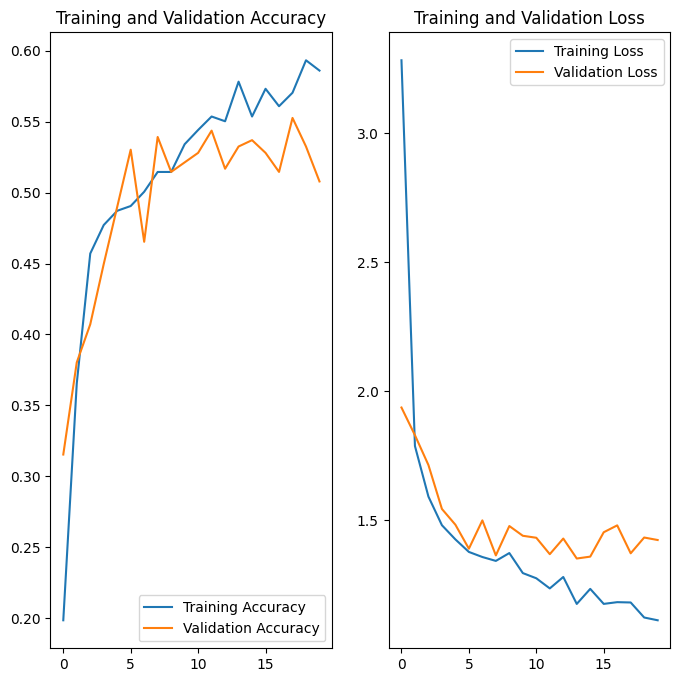

In [23]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings:
Here are the observations from the model training process:

1. Training Accuracy vs. Validation Accuracy:
    * As the model trains, the training accuracy consistently increases.
    * However, the validation accuracy reaches around 50% and plateaus.
    * This indicates that the model performs well on the training data but struggles to generalize to unseen validation data.
2. Training Loss vs. Validation Loss:
    * The training loss decreases as the model trains over epochs.
    * Surprisingly, the validation loss also decreases but eventually stalls.
    * This divergence suggests overfitting—where the model fits too closely to the training data.
3. Accuracy Gap:
    * The gap between training accuracy and validation accuracy has decreased compared to the previous model.
    * The model achieves approximately 50% accuracy on the validation set.
    * However, a noticeable difference still exists, indicating potential overfitting.

In summary, addressing overfitting remains crucial for better generalization

# Model Building & training on the augmented data with dropout :

We’re embarking on the following steps to build and train a Convolutional Neural Network (CNN) model using augmented data and incorporating dropout:

1. Model Creation:
    * Our goal is to create a CNN model capable of accurately detecting 9 different classes present in the dataset.
    * During model construction, we’ll rescale the images to normalize pixel values within the range of (0, 1).
2. Optimization and Loss Function Selection:
    * We’ll carefully choose an appropriate optimizer and loss function for training the model.
    * The optimizer guides the model’s weight updates during training, while the loss function quantifies the difference between predicted and actual values.
3. Training the Model with Dropout:
    * We’ll train the model for approximately 20 epochs (training iterations).
    * Additionally, we’ll incorporate dropout—a regularization technique that randomly drops out some neurons during training.
    * Dropout helps prevent overfitting by reducing reliance on specific neurons and promoting better generalization.
4. Graph Plotting for Evaluation:
    * After fitting the model, we’ll analyze the results.
    * By plotting graphs, we’ll assess whether the model exhibits signs of overfitting (memorizing the training data) or underfitting (lacking complexity).

Our aim is to create a robust CNN model that performs well across the 9 different classes while addressing overfitting concerns.

In [24]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.1817 - loss: 7.1956 - val_accuracy: 0.2282 - val_loss: 2.0427
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.2740 - loss: 1.9564 - val_accuracy: 0.3982 - val_loss: 1.7620
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3743 - loss: 1.7374 - val_accuracy: 0.4385 - val_loss: 1.6158
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.4565 - loss: 1.5498 - val_accuracy: 0.4609 - val_loss: 1.4873
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4918 - loss: 1.4295 - val_accuracy: 0.5190 - val_loss: 1.4773
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5016 - loss: 1.3931 - val_accuracy: 0.5369 - val_loss: 1.4413
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.5054 - loss: 1.4399 - val_accuracy: 0.5391 - val_loss: 1.4231
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.5397 - loss: 1.2876 - val_accuracy: 0.5369 - val_loss: 1.

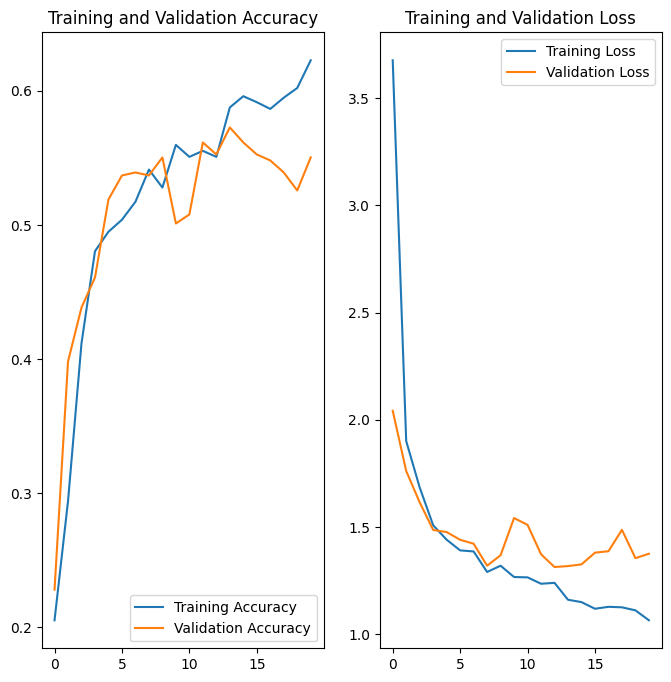

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Findings:
Here are the observations from the model training process:

1. Training Accuracy vs. Validation Accuracy:
    * As the model trains, the training accuracy consistently increases.
    * Interestingly, the validation accuracy also increases but eventually stalls at around 55%.
    * This suggests that the model performs well on the training data but struggles to generalize to unseen validation data.
2. Training Loss vs. Validation Loss:
    * The training loss decreases as the model trains over epochs.
    * Surprisingly, the validation loss also decreases during the same period.
    * This convergence indicates that the model is learning effectively.
3. Accuracy Gap:
    * The gap between training accuracy and validation accuracy has decreased compared to the previous model.
    * The model achieves approximately 55% accuracy on the validation set.
    * The small difference in accuracy between training and validation is a positive sign, indicating better generalization.

In summary, the model is showing improved performance, and the overfitting issue has been mitigated.

**We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

# Class distribution:

We are currently examining the class distribution within the training dataset. This analysis is essential because datasets often exhibit class imbalance, where certain classes have significantly more samples than others. Such imbalance can adversely affect the final model’s quality. As a sanity check, we need to understand how the different classes are distributed. Detecting class imbalance early allows us to address potential issues during model training. By ensuring a balanced representation of classes, we can build a more robust and accurate model.

In [28]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


### Findings - 
#### - Which class has the least number of samples?
- seborrheic keratosis has the least number with 77 samples

#### - Which classes dominate the data in terms proportionate number of samples?
- pigmented benign keratosis with 462 samples


# Handling Class Imbalances:

Rectifying class imbalances present in the training dataset with Augmentor library.

In [29]:
!pip install Augmentor

  Using cached Augmentor-0.2.12-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tqdm-4.66.4-py3-none-any.whl.metadata (57 kB)
Using cached Augmentor-0.2.12-py2.py3-none-any.whl (38 kB)
Using cached tqdm-4.66.4-py3-none-any.whl (78 kB)


In [32]:
path_to_training_dataset= "D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
   p = Augmentor.Pipeline(path_to_training_dataset + i)
   p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
   p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A77CEB7800>: 100%|██████████| 500/500 [00:03<00:00, 149.75 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A9504C6FC0>: 100%|██████████| 500/500 [00:03<00:00, 136.80 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A768FFF1A0>: 100%|██████████| 500/500 [00:03<00:00, 150.52 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1A766997D70>: 100%|██████████| 500/500 [00:17<00:00, 28.93 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x1A77B8E3F20>: 100%|██████████| 500/500 [00:14<00:00, 34.40 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1A764936420>: 100%|██████████| 500/500 [00:04<00:00, 112.12 Samples/s]


Initialised with 77 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x1A764635580>: 100%|██████████| 500/500 [00:07<00:00, 68.82 Samples/s]


Initialised with 181 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A7669DF2C0>: 100%|██████████| 500/500 [00:03<00:00, 144.62 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1A764A0D820>: 100%|██████████| 500/500 [00:03<00:00, 147.03 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
data_dir_train =("D:/Upgrad Docs/Skin Cancer/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")

### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [35]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [36]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


##### So here we can see we have added around 4500 new images using augmentor. So now the total no of images are 4500 + 2239 = 6739 images

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


# Model Building & training on the rectified class imbalance data :

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [39]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
#model.add(BatchNormalization())
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [40]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 259200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    66,355,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,433,417 (253.42 MB)

 Trainable params: 66,433,417 (253.42 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


169/169 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.2419 - loss: 3.8300 - val_accuracy: 0.2717 - val_loss: 2.0665
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.3809 - loss: 1.6612 - val_accuracy: 0.4321 - val_loss: 1.5290
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.4474 - loss: 1.4537 - val_accuracy: 0.4581 - val_loss: 1.4185
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 328s 2s/step - accuracy: 0.4890 - loss: 1.3367 - val_accuracy: 0.4469 - val_loss: 1.4096
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.4879 - loss: 1.3169 - val_accuracy: 0.5122 - val_loss: 1.2456
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.5241 - loss: 1.2239 - val_accuracy: 0.5397 - val_loss: 1.1964
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.5697 - loss: 1.1414 - val_accuracy: 0.5813 - val_loss: 1.1165
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.5810 - loss: 1.0966 - val_accuracy: 0.532

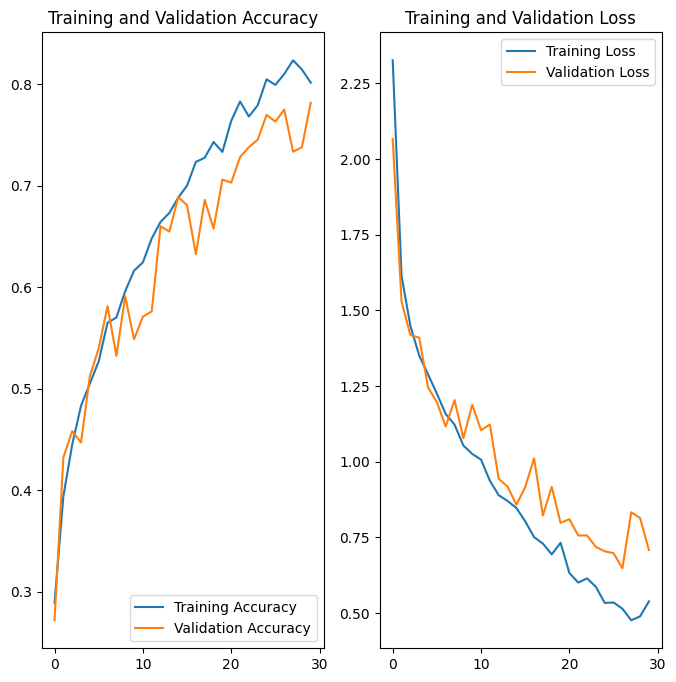

In [42]:
# Visualizing model results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Conclusion

Here are the key findings from our model training process:

1. **Training Accuracy vs. Validation Accuracy**:
    * As the model trains, the training accuracy consistently `improves`.
    * Simultaneously, the validation accuracy also `increases` during training.
    * This positive trend indicates that the model is learning effectively.
2. **Training Loss vs. Validation Loss**:
    * The training loss `decreases` as the model trains over epochs.
    * Remarkably, the validation loss also `decreases` in tandem.
    * This convergence suggests that the model is generalizing well.
3. **Accuracy Gap Reduction**:
    * Compared to the previous model, the gap between training accuracy and validation accuracy has `significantly decreased`.
    * The model achieves approximately `78% accuracy` on the validation set.
    * This improvement is promising.
4. **Class Rebalancing Impact**:
    * Addressing class imbalance not only mitigated overfitting but also substantially improved accuracy—from 55% to 78%.

In summary, our efforts have led to a **more balanced and accurate** model.